In [1]:
from sklearn.preprocessing import StandardScaler
import scipy.io as sio
import numpy as np
import argparse

import h5py
import time
import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
from torchsummary import summary
import torch.backends.cudnn as cudnn

from auxiliary_classifier import S3KAIResNet
from data_prepare import mirror_hsi
from sklearn.metrics import confusion_matrix

from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch

from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label

from Utils import plot_confusion_matrix, print_args
from Utils import output_metric, classification_map, list_to_colormap


import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("A2S2KResNet")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion) 
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (528, 9, 9, 176), type = float64
x_test  shape = (4683, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************
y_train: shape = (528,), type = int64
y_test: shape = (4683,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [8]:
# load data
x_train = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)  # (13, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true).unsqueeze(1).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([528, 1, 9, 9, 176])
torch.Size([4683, 1, 9, 9, 176])
torch.Size([5211, 1, 9, 9, 176])


In [9]:
net = S3KAIResNet(band, num_classes, 2).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)

In [ ]:
tic = time.time()
for epoch in range(args.epoches):
    # train model
    net.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(net, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


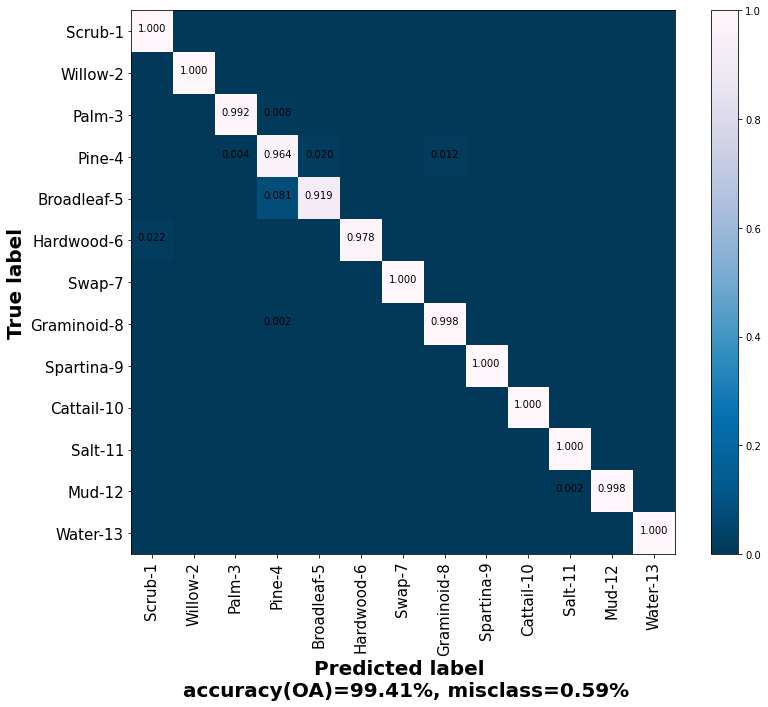

In [10]:
net.eval()
tar_test, pre_test = auxiliary_test_epoch(net, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(net, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_A2S2K-ResNet.pdf')

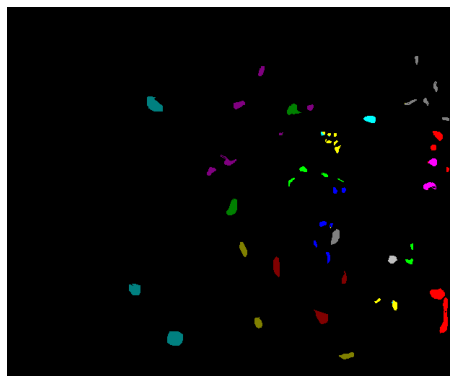

In [11]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
true_map = list_to_colormap(label.ravel())
true_map = np.reshape(true_map, (height, width, 3))
#classification_map(true_map, 300, './GT.pdf')
classification_map(predict_map, './Predict_Map_A2S2.pdf')

In [12]:
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))

Final result:
OA: 99.34% | AA: 98.71% | Kappa: 0.9926
[1.         1.         0.99130435 0.96017699 0.90972222 0.97572816
 1.         0.99741602 1.         1.         1.         0.99778761
 1.        ]
**************************************************
Parameter:
dataset: KSC
seed: 0
batch_size: 32
patch_size: 9
epoches: 200
learning_rate: 0.001
gamma: 0.99
train_number: 1
train_proportion: 0.1
